# eSure Data Science Brief
_______

### Executive summary
Given a home insurance dataset covering 2007 - 2012, this notebook details an exploration of the dataset and development of a model that predicts future lapsed cases.

In the [Data Exploration section](#1-data-exploration), the dataset is explored and the process behind the data processing is justified.
In the [Data Modelling](#2-data-modelling) section, the dataset cleaning operations are summarised in a class structure called `Housingdata`. This section features model training and evaluation analysis. 
The [Conclusion](#3-conclusions) section details concluding remarks and further work required.
_______

### 0. Import modules

In [3]:
import pandas as pd
import numpy as np
import logging
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# 1. Data exploration

## Loading the data

In [2]:
data_path = "../data/raw/home_insurance.csv"
df = pd.read_csv(data_path, header=0)
df_copy = df.copy() # copy 

In [3]:
df.head()

,QUOTE_DATE,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,P1_PT_EMP_STATUS,BUS_USE,CLERICAL,AD_BUILDINGS,RISK_RATED_AREA_B,SUM_INSURED_BUILDINGS,...,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,MTA_FAP,MTA_APRP,MTA_DATE,LAST_ANN_PREM_GROSS,POL_STATUS,i,Police
0,11/22/2007,22/11/2007,N,R,NaN,N,NaN,Y,19.0,1000000.0,...,N,N,N,NaN,NaN,NaN,274.81,Lapsed,1,P000001
1,11/22/2007,01/01/2008,N,E,NaN,Y,N,Y,25.0,1000000.0,...,N,N,Y,308.83,-9.27,NaN,308.83,Live,2,P000002
2,11/23/2007,23/11/2007,N,E,NaN,N,NaN,N,NaN,0.0,...,N,N,Y,52.65,52.65,03/11/2010,52.65,Live,3,P000003
3,11/23/2007,12/12/2007,N,R,NaN,N,NaN,N,NaN,0.0,...,N,N,N,NaN,NaN,NaN,54.23,Live,4,P000004
4,11/22/2007,15/12/2007,N,R,NaN,N,NaN,Y,5.0,1000000.0,...,N,N,N,NaN,NaN,NaN,244.58,Live,5,P000005


In [4]:
# creating target variable
df['lapsed'] = np.where(df["POL_STATUS"] == "Lapsed", 1, 0)

## Understanding the data


In [5]:
def log_df(df: "pd.DataFrame", filename) -> None:
    """Logging function to display %null values, and number of unique values for
        a given dataframe.

        Args:
            df: pd.DataFrame
            msg: string to print at top of log

    """
    with open(filename, 'w') as f:
        f.write(f"Length of dataframe: {len(df)}"+ "\n")
        f.write("| "+"COLUMN".rjust(23)+
        " | "+"DTYPE".rjust(15)+
        " | "+"% NULL".rjust(8)+
        " | "+"UNIQUE VALUES LENGTH | ".rjust(10)+
        "SAMPLE (display all unique values if len < 10)".rjust(20)
        + "\n")
        f.write("|"+"-"*144 + "\n")
        for i in sorted(df.columns):
            num_nulls = round(df[i].isnull().mean()*100,1)
            if len(df[i].unique()) < 10:
                f.write(f"| {i:>23} | {str(df.dtypes[i]):>15} | {num_nulls:>8} | {len(df[i].unique()):>20} | {df[i].unique()}"+ "\n")
            else:
                f.write(f"| {i:>23} | {str(df.dtypes[i]):>15} | {num_nulls:>8} | {len(df[i].unique()):>20} | {df[i][df[i].notna()].sample(2).values}"+ "\n")
        f.write("\n")
    return None

In [6]:
log_df(df, "data_overview")

Analysing the above `data_overview.txt` gives an insight into how to process the data. It provides information on data type, percentage null values, and number of unique values along with a sample of these.

The variable names are included with their descriptions below. 

Some columns can be dropped immediately in this first batch of pre-processing, summarised with the reason below:

| *Column*         | *Reason to be dropped* |
| -: | -: |
| i           |    All values are unique    |
| CAMPAIGN_DESC      |   All values are null     |

For now, `Police` will be kept as a unique policy identifier, even though it contains entirely unique values. It won't be useful for predictive capacity but may be useful in future for other purposes.



In [7]:
df.drop(["i", "CAMPAIGN_DESC"],
axis = 1, inplace = True)
df.head()

,QUOTE_DATE,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,P1_PT_EMP_STATUS,BUS_USE,CLERICAL,AD_BUILDINGS,RISK_RATED_AREA_B,SUM_INSURED_BUILDINGS,...,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,MTA_FAP,MTA_APRP,MTA_DATE,LAST_ANN_PREM_GROSS,POL_STATUS,Police,lapsed
0,11/22/2007,22/11/2007,N,R,NaN,N,NaN,Y,19.0,1000000.0,...,N,N,N,NaN,NaN,NaN,274.81,Lapsed,P000001,1
1,11/22/2007,01/01/2008,N,E,NaN,Y,N,Y,25.0,1000000.0,...,N,N,Y,308.83,-9.27,NaN,308.83,Live,P000002,0
2,11/23/2007,23/11/2007,N,E,NaN,N,NaN,N,NaN,0.0,...,N,N,Y,52.65,52.65,03/11/2010,52.65,Live,P000003,0
3,11/23/2007,12/12/2007,N,R,NaN,N,NaN,N,NaN,0.0,...,N,N,N,NaN,NaN,NaN,54.23,Live,P000004,0
4,11/22/2007,15/12/2007,N,R,NaN,N,NaN,Y,5.0,1000000.0,...,N,N,N,NaN,NaN,NaN,244.58,Live,P000005,0


In [8]:
print(df.select_dtypes(include=["object"]).columns)
print(len(df.select_dtypes(include=["object"]).columns), " columns are categorical")

Index(['QUOTE_DATE', 'COVER_START', 'CLAIM3YEARS', 'P1_EMP_STATUS',
       'P1_PT_EMP_STATUS', 'BUS_USE', 'CLERICAL', 'AD_BUILDINGS',
       'AD_CONTENTS', 'CONTENTS_COVER', 'BUILDINGS_COVER', 'P1_DOB',
       'P1_MAR_STATUS', 'P1_POLICY_REFUSED', 'P1_SEX', 'APPR_ALARM',
       'APPR_LOCKS', 'FLOODING', 'NEIGH_WATCH', 'OCC_STATUS', 'SAFE_INSTALLED',
       'SEC_DISC_REQ', 'SUBSIDENCE', 'PAYMENT_METHOD', 'LEGAL_ADDON_PRE_REN',
       'LEGAL_ADDON_POST_REN', 'HOME_EM_ADDON_PRE_REN',
       'HOME_EM_ADDON_POST_REN', 'GARDEN_ADDON_PRE_REN',
       'GARDEN_ADDON_POST_REN', 'KEYCARE_ADDON_PRE_REN',
       'KEYCARE_ADDON_POST_REN', 'HP1_ADDON_PRE_REN', 'HP1_ADDON_POST_REN',
       'HP2_ADDON_PRE_REN', 'HP2_ADDON_POST_REN', 'HP3_ADDON_PRE_REN',
       'HP3_ADDON_POST_REN', 'MTA_FLAG', 'MTA_DATE', 'POL_STATUS', 'Police'],
      dtype='object')
42  columns are categorical


In [9]:
print(df.select_dtypes(exclude=["object"]).columns)
print(len(df.select_dtypes(exclude=["object"]).columns), " columns are numerical")

Index(['RISK_RATED_AREA_B', 'SUM_INSURED_BUILDINGS', 'NCD_GRANTED_YEARS_B',
       'RISK_RATED_AREA_C', 'SUM_INSURED_CONTENTS', 'NCD_GRANTED_YEARS_C',
       'SPEC_SUM_INSURED', 'SPEC_ITEM_PREM', 'UNSPEC_HRP_PREM', 'BEDROOMS',
       'ROOF_CONSTRUCTION', 'WALL_CONSTRUCTION', 'LISTED', 'MAX_DAYS_UNOCC',
       'OWNERSHIP_TYPE', 'PAYING_GUESTS', 'PROP_TYPE', 'YEARBUILT',
       'PAYMENT_FREQUENCY', 'MTA_FAP', 'MTA_APRP', 'LAST_ANN_PREM_GROSS',
       'lapsed'],
      dtype='object')
23  columns are numerical


#### Data overview
Before the removal of `i` and `CAMPAIGN_DESC` there were 65 features and 256136 rows. 
Many of these features have the data type "object", usually referring to string. This needs to be processed for later modelling. 
Of these 64 features:
 - 4 were string objects relating to a date. Not including `YEAR_BUILT` which is stored as a float.
 - 38 columns were categorical (42 less the 4 date objects)
 - 23 columns were numerical.

The feature descriptions for each are listed below (taken from https://www.kaggle.com/datasets/ycanario/home-insurance):
 - QUOTE_DATE: Day where the quotation was made
 - COVER_START: Beginning of the cover payment
 - CLAIM3YEARS: 3 last years loss
 - P1EMPSTATUS: Client's professional status
 - P1PTEMP_STATUS: Client's part-time professional status
 - BUS_USE: Commercial use indicator
 - CLERICAL: Administration office usage indicator
 - AD_BUILDINGS: Building coverage - Self damage
 - RISKRATEDAREA_B: Geographical Classification of Risk - Building
 - SUMINSUREDBUILDINGS: Assured Sum - Building
 - NCDGRANTEDYEARS_B: Bonus Malus - Building
 - AD_CONTENTS: Coverage of personal items - Self Damage
 - RISKRATEDAREA_C: Geographical Classification of Risk - Personal Objects
 - SUMINSUREDCONTENTS: Assured Sum - Personal Items
 - NCDGRANTEDYEARS_C: Malus Bonus - Personal Items
 - CONTENTS_COVER: Coverage - Personal Objects indicator
 - BUILDINGS_COVER: Cover - Building indicator
 - SPECSUMINSURED: Assured Sum - Valuable Personal Property
 - SPECITEMPREM: Premium - Personal valuable items
 - UNSPECHRPPREM: Unknown
 - P1_DOB: Date of birth of the client
 - P1MARSTATUS: Marital status of the client
 - P1POLICYREFUSED: Police Emission Denial Indicator
 - P1_SEX: customer sex
 - APPR_ALARM: Appropriate alarm
 - APPR_LOCKS: Appropriate lock
 - BEDROOMS: Number of bedrooms
 - ROOF_CONSTRUCTION: Code of the type of construction of the roof
 - WALL_CONSTRUCTION: Code of the type of wall construction
 - FLOODING: House susceptible to floods
 - LISTED: National Heritage Building
 - MAXDAYSUNOCC: Number of days unoccupied
 - NEIGH_WATCH: Vigils of proximity present
 - OCC_STATUS: Occupancy status
 - OWNERSHIP_TYPE: Type of membership
 - PAYING_GUESTS: Presence of paying guests
 - PROP_TYPE: Type of property
 - SAFE_INSTALLED: Safe installs
 - SECDISCREQ: Reduction of premium for security
 - SUBSIDENCE: Subsidence indicator (relative downwards motion of the surface )
 - YEARBUILT: Year of construction
 - CAMPAIGN_DESC: Description of the marketing campaign
 - PAYMENT_METHOD: Method of payment
 - PAYMENT_FREQUENCY: Frequency of payment
 - LEGALADDONPRE_REN: Option "Legal Fees" included before 1st renewal
 - LEGALADDONPOST_REN: Option "Legal Fees" included after 1st renewal
 - HOMEEMADDONPREREN: "Emergencies" option included before 1st renewal
 - HOMEEMADDONPOSTREN: Option "Emergencies" included after 1st renewal
 - GARDENADDONPRE_REN: Option "Gardens" included before 1st renewal
 - GARDENADDONPOST_REN: Option "Gardens" included after 1st renewal
 - KEYCAREADDONPRE_REN: Option "Replacement of keys" included before 1st renewal
 - KEYCAREADDONPOST_REN: Option "Replacement of keys" included after 1st renewal
 - HP1ADDONPRE_REN: Option "HP1" included before 1st renewal
 - HP1ADDONPOST_REN: Option "HP1" included after 1st renewal
 - HP2ADDONPRE_REN: Option "HP2" included before 1st renewal
 - HP2ADDONPOST_REN: Option "HP2" included afterrenewal
 - HP3ADDONPRE_REN: Option "HP3" included before 1st renewal
 - HP3ADDONPOST_REN: Option "HP3" included after renewal
 - MTA_FLAG: Mid-Term Adjustment indicator
 - MTA_FAP: Bonus up to date of Adjustment
 - MTA_APRP: Adjustment of the premium for Mid-Term Adjustmen
 - MTA_DATE: Date of Mid-Term Adjustment
 - LASTANNPREM_GROSS: Premium - Total for the previous year
 - POL_STATUS: Police status
 - Police: Police number

### Date related features

It is shown above that of the five columns referring to a date, `YEARBUILT` is the only one listed as a float. `COVER_START`, `P1_DOB`, `MTA_DATE` all have the format DD-MM-YYYY, whereas `QUOTE_DATE` has the format MM-DD-YYYY.

In [10]:
df[["QUOTE_DATE", "COVER_START", "P1_DOB", "MTA_DATE", "YEARBUILT"]].head()

,QUOTE_DATE,COVER_START,P1_DOB,MTA_DATE,YEARBUILT
0,11/22/2007,22/11/2007,15/06/1939,NaN,1960.0
1,11/22/2007,01/01/2008,20/05/1970,NaN,1960.0
2,11/23/2007,23/11/2007,10/06/1947,03/11/2010,1946.0
3,11/23/2007,12/12/2007,16/12/1925,NaN,1870.0
4,11/22/2007,15/12/2007,11/02/1936,NaN,1960.0


In [11]:
# Date-related featrues
df["QUOTE_DATE"] = pd.to_datetime(df["QUOTE_DATE"], format="%m/%d/%Y")
df["COVER_START"] = pd.to_datetime(df["COVER_START"], format="%d/%m/%Y")
df["P1_DOB"] = pd.to_datetime(df["P1_DOB"], format="%d/%m/%Y")
df["MTA_DATE"] = pd.to_datetime(df["MTA_DATE"], format="%d/%m/%Y")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

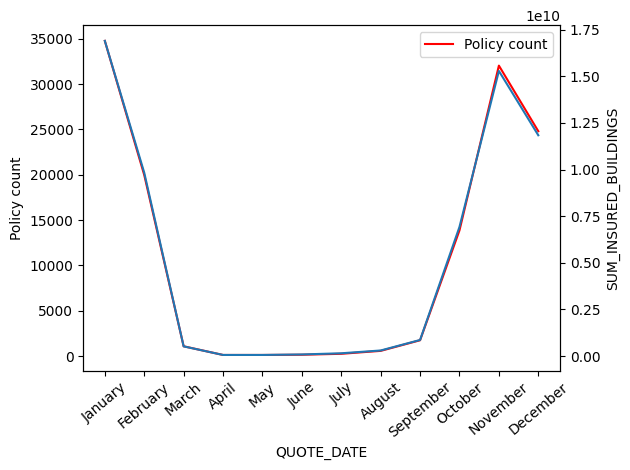

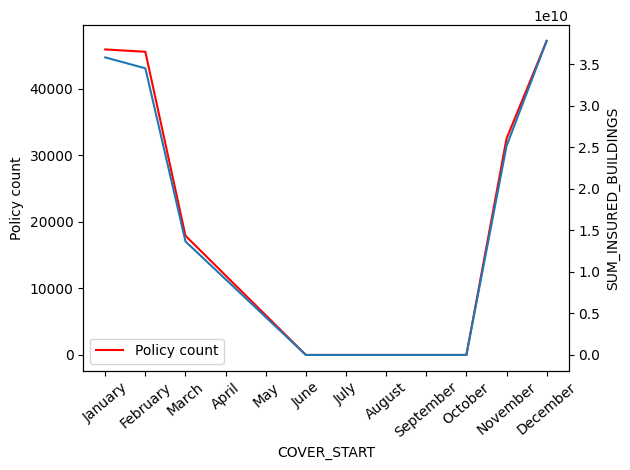

In [12]:
months = ['January', 'February', 'March', 'April', 'May',
'June', 'July', 'August', 'September', 'October', 'November','December']

# Figure 1
policies_by_month = df["Police"].groupby(by=df["QUOTE_DATE"].dt.month_name()).count()
sum_insured_contents_by_month = df["SUM_INSURED_BUILDINGS"].groupby(by=df["QUOTE_DATE"].dt.month_name()).sum()
fig, ax = plt.subplots(1,1, tight_layout=True)
ax2 = ax.twinx()
sns.lineplot(policies_by_month.reindex(months), color = 'red', label = 'Policy count', ax=ax)
sns.lineplot(sum_insured_contents_by_month.reindex(months), ax=ax2)
ax.set_ylabel("Policy count")
plt.sca(ax)
plt.xticks(rotation=40)

# Figure 2
policies_by_month = df["Police"].groupby(by=df["COVER_START"].dt.month_name()).count()
sum_insured_contents_by_month = df["SUM_INSURED_BUILDINGS"].groupby(by=df["COVER_START"].dt.month_name()).sum()
fig, ax = plt.subplots(1,1, tight_layout=True)
ax2 = ax.twinx()
sns.lineplot(policies_by_month.reindex(months), color = 'red', label = 'Policy count', ax=ax)
sns.lineplot(sum_insured_contents_by_month.reindex(months), ax=ax2)
ax.set_ylabel("Policy count")
plt.sca(ax)
plt.xticks(rotation=40)

Shown in the figure above, there is a clear seasonality when it comes to policies. Both number of policies written and the total sum of insured building value.

<AxesSubplot:xlabel='RISK_RATED_AREA_C', ylabel='Count'>

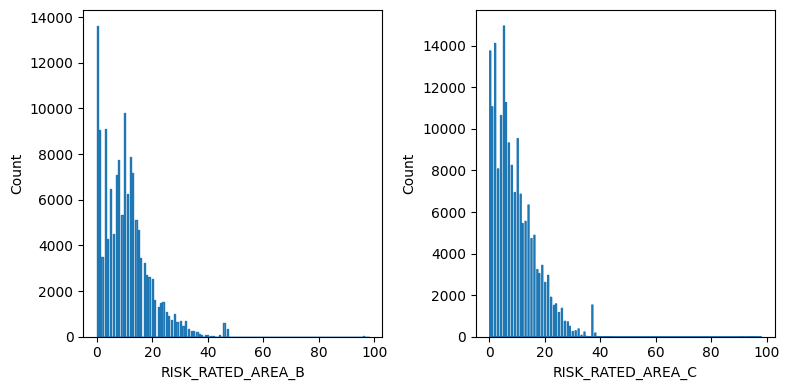

In [13]:
fig, ax = plt.subplots(1,2, figsize = (8,4), tight_layout=True)
ax=ax.ravel()
sns.histplot(df["RISK_RATED_AREA_B"], element="step", ax=ax[0])
sns.histplot(df["RISK_RATED_AREA_C"], element="step", ax=ax[1])

The two features `RISK_RATED_AREA_B` and `RISK_RATED_AREA_C` are features relating to the geographical classification of risk. They both contain missing values, and these are chosen to be imputed by using the median, not the mean, of the distributions due to their positive skew. 

<AxesSubplot:>

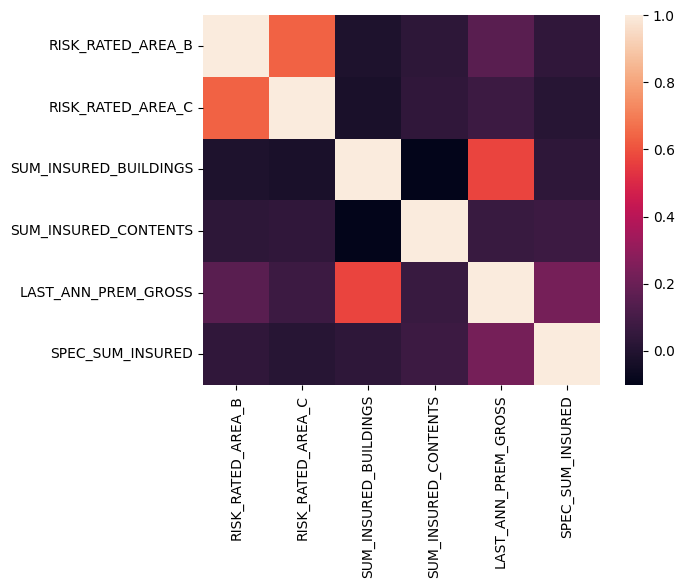

In [14]:
features = ['RISK_RATED_AREA_B', 'RISK_RATED_AREA_C', 'SUM_INSURED_BUILDINGS','SUM_INSURED_CONTENTS','LAST_ANN_PREM_GROSS', 'SPEC_SUM_INSURED',]
corr = df.loc[:,features].corr()
sns.heatmap(corr)

A concise correlation plot of a few chosen continuous variables is shown. RISK_RATED_AREA_B and RISK_RATED_AREA_C show a high correlation, as well as SUM_INSURED_BUILDINGS and LAST_ANN_PREM_GROSS.

In [ ]:
#features = ['RISK_RATED_AREA_B', 'RISK_RATED_AREA_C', 'SUM_INSURED_BUILDINGS','SUM_INSURED_CONTENTS','LAST_ANN_PREM_GROSS', 'SPEC_SUM_INSURED','lapsed']
#
#g = sns.pairplot(data = df.loc[0:20,features], 
#                hue = 'lapsed', diag_kind = 'hist', vars = df.loc[:,features].columns[:-1], 
#                height = 2, aspect=1,
#                plot_kws=dict(alpha=0.5), diag_kws=dict(alpha=0.5))
#plt.show()

## Missing data - Identifying and handling

Many features in `data_overview.txt` list a null percentage of 26.2% which warrants further investigation. 

In [15]:
print("Target feature distribution (%):")
df["POL_STATUS"].value_counts(normalize=True, dropna = False).mul(100)

Target feature distribution (%):


Live         51.597589
NaN          26.202877
Lapsed       20.510198
Cancelled     1.683090
Unknown       0.006247
Name: POL_STATUS, dtype: float64

The `POL_STATUS` feature will contain the target variable to be predicted. As shown above, the distribution of this feature, there are 26.2% NaN values. Further investigation is needed to see what this null data contains.

In [16]:
mask = df["POL_STATUS"].notnull()
log_df(df[~mask], "Testing_POL_STATUS_NULL_mask")

As shown in this log data in `Testing_POL_STATUS_NULL_MASK.txt`, most of the data flagged as NaN under `POL_STATUS` also has NaN flags elsewhere, and so removing this completely is an acceptable choice. Had this data contained meaningful insights for other predictor variables it may have made sense to keep it.

In [17]:
df.drop(df[~mask].index, axis = 0, inplace = True) # drop null values from mask
df = df[(df["POL_STATUS"] != "Unknown")] # drop unknown values
log_df(df, "Processing_POL_STATUS_Null_dropped")

In [18]:
print(df["PAYMENT_FREQUENCY"].value_counts(dropna=False))
print()
print(df["CLERICAL"].value_counts(dropna=False))

NaN    108455
1.0     80550
Name: PAYMENT_FREQUENCY, dtype: int64

NaN    186061
Y        2644
N         300
Name: CLERICAL, dtype: int64


Some features still contain NaN values. Both `PAYMENT_FREQUENCY` and `CLERICAL` have their null values filled with 0s. 
For payment frequency the assumption is that this flag is not activated in the NaN rows. For Clerical the assumption is that if it has not been flagged as "Y" it is a "N". 

In [19]:
df["PAYMENT_FREQUENCY"].fillna(0, inplace = True)
df["CLERICAL"].fillna("N")

0         N
1         N
2         N
3         N
4         N
         ..
256131    N
256132    N
256133    N
256134    N
256135    N
Name: CLERICAL, Length: 189005, dtype: object

In [20]:
print(df[(df["MTA_FLAG"] == 'N')][["MTA_FAP", "MTA_APRP"]].head(10))
df[["MTA_FAP", "MTA_APRP"]].fillna(0, inplace = True)



    MTA_FAP  MTA_APRP
0       NaN       NaN
3       NaN       NaN
4       NaN       NaN
5       NaN       NaN
7       NaN       NaN
9       NaN       NaN
11      NaN       NaN
12      NaN       NaN
13      NaN       NaN
14      NaN       NaN


/tmp/ipykernel_8658/1328303589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["MTA_FAP", "MTA_APRP"]].fillna(0, inplace = True)


In [22]:
df["MTA_DATE_DIFF"] = (df["MTA_DATE"] - df["COVER_START"]).dt.days
df["MTA_DATE_DIFF"].fillna(0)

0            0.0
1            0.0
2         1076.0
3            0.0
4            0.0
           ...  
256131       0.0
256132    3652.0
256133       0.0
256134       0.0
256135       0.0
Name: MTA_DATE_DIFF, Length: 189005, dtype: float64

The NaN values in MTA related features are dependent on the `MTA_FLAG` feature. If it is "N", then the corresponding values in MTA columns are NaN. `MTA_FAP` and `MTA_APRP` relate to numeric values in monetary value, and so filling these NaNs with 0s seems reasonable. 

It was decided to drop the date predictor variables for `MTA_DATE_` at this point due to the high null count. It is possible to impute values for these, but they would be non-sensi

In [23]:
df["QUOTE_DATE_FLAG"] = df["QUOTE_DATE"].notna().astype(int)
df["QUOTE_DATE_DIFF"] = (df["QUOTE_DATE"] - df["COVER_START"]).dt.days
df["QUOTE_DATE_DIFF"].fillna(0, inplace=True)
print("Number of policies with quote date after cover start:", (df["QUOTE_DATE_DIFF"] > 0).sum())
print("Number of policies with quote date before cover start:",(df["QUOTE_DATE_DIFF"] < 0).sum())

Number of policies with quote date after cover start: 475
Number of policies with quote date before cover start: 70299


## Data processing overview class

The processing operations to clean the dataset are summarised in the class below in order to keep things tidy and more concise.

In [1]:
class Housingdata:
    def _run(self) -> "pd.DataFrame":
        return self._load().pipe(self._clean)

    def _load(self) -> "pd.DataFrame":
        data_path = "../data/raw/home_insurance.csv"
        df = pd.read_csv(data_path, header=0)
        return df

    #@log_time
    def _clean(self, df: "pd.DataFrame") -> "pd.DataFrame":
        """Prepare the input data for training

        Args:
            df (pd.DataFrame): raw data

    
        Returns:
            df (pd.DataFrame): clean dataset
        """

        # Create target variable
        df['lapsed'] = np.where(df["POL_STATUS"] == "Lapsed", 1, 0)

        #Initial drop
        df.drop(["i", "CAMPAIGN_DESC"], axis = 1, inplace = True)


        # Date-related features
        df["QUOTE_DATE"] = pd.to_datetime(df["QUOTE_DATE"], format="%m/%d/%Y")
        df["COVER_START"] = pd.to_datetime(df["COVER_START"], format="%d/%m/%Y")
        df["P1_DOB"] = pd.to_datetime(df["P1_DOB"], format="%d/%m/%Y")
        df["MTA_DATE"] = pd.to_datetime(df["MTA_DATE"], format="%d/%m/%Y")

        dt_cols = ["QUOTE_DATE", "COVER_START", "P1_DOB", "MTA_DATE"]
        for i in dt_cols:
            df[i+"_YEAR"] = df[i].dt.year
            df[i+"_MONTH"] = df[i].dt.month
            df[i+"_WEEK"] = df[i].dt.isocalendar().week
            df[i+"_DAY"] = df[i].dt.dayofweek


        # drop null/unknown values for pol_status
        df.drop(df[df["POL_STATUS"].isna()].index, axis = 0, inplace = True) # drop null values from mask
        df = df[(df["POL_STATUS"] != "Unknown")] # drop unknown values


        # fill missing values
        df["PAYMENT_FREQUENCY"] = df["PAYMENT_FREQUENCY"].fillna(0)
        df["CLERICAL"] = df["CLERICAL"].fillna("N") 
        df["MTA_FAP"] = df["MTA_FAP"].fillna(0)
        df["MTA_APRP"] = df["MTA_APRP"].fillna(0)
    
        # Date feature: MTA
        df["MTA_DATE_DIFF"] = (df["MTA_DATE"] - df["COVER_START"]).dt.days
        df["MTA_DATE_DIFF"] = df["MTA_DATE_DIFF"].fillna(0)
        df.drop(["MTA_DATE_DAY",
                "MTA_DATE_WEEK",
                "MTA_DATE_MONTH",
                "MTA_DATE_YEAR"], axis = 1, inplace = True)      

        # Date feature: QUOTE
        df["QUOTE_DATE_FLAG"] = df["QUOTE_DATE"].notna().astype(int)
        df["QUOTE_DATE_DIFF"] = (df["QUOTE_DATE"] - df["COVER_START"]).dt.days
        df["QUOTE_DATE_DIFF"] = df["QUOTE_DATE_DIFF"].fillna(0)
        df.drop(["QUOTE_DATE_DAY",
                "QUOTE_DATE_WEEK",
                "QUOTE_DATE_MONTH",
                "QUOTE_DATE_YEAR"], axis = 1, inplace = True)

        # Date feature: COVER LENGTH
        df["COVER_LENGTH"] = 2013 - df["COVER_START"].dt.year
        df["COVER_LENGTH"] = df["COVER_LENGTH"].fillna(0)


        # Impute missing value
        df["RISK_RATED_AREA_B_imputed"] = df["RISK_RATED_AREA_B"].fillna(
            df["RISK_RATED_AREA_B"].median()
        )
        df["RISK_RATED_AREA_C_imputed"] = df["RISK_RATED_AREA_C"].fillna(
            df["RISK_RATED_AREA_C"].median()
        )


        # One-hot encode data
        df.drop(["Police"], axis=1, inplace=True)
        dummies = pd.get_dummies(
            df.select_dtypes(include=[object]), #cols to be encoded
            drop_first=True,
            #prefix=df.columns,

        )
        df = pd.concat([df.select_dtypes(exclude=[object]), dummies], 1)


        #final drop
        df.drop(["POL_STATUS_Live",
        "QUOTE_DATE",
        "COVER_START",
        "MTA_DATE",
        "P1_DOB",
        "RISK_RATED_AREA_B",
        "RISK_RATED_AREA_C",
        "POL_STATUS_Lapsed"
        ], axis=1, inplace=True)

        # type casting for Xgboost
        df["COVER_START_WEEK"] = df["COVER_START_WEEK"].astype(int)
        df["P1_DOB_WEEK"] = df["P1_DOB_WEEK"].astype(int)

        return df


# 2. Data Modelling

In [4]:
df = Housingdata()._run()

/tmp/ipykernel_257/471640331.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PAYMENT_FREQUENCY"] = df["PAYMENT_FREQUENCY"].fillna(0)
/tmp/ipykernel_257/471640331.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CLERICAL"] = df["CLERICAL"].fillna("N")
/tmp/ipykernel_257/471640331.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [35]:
log_df(df, "cleaned_data")

In [6]:
X = df.drop(["lapsed"], axis=1)

y = df["lapsed"]

In [37]:
print(round(sum(y)/len(y)*100, 2), "%")

27.8 %


As shown above, 28% of policies have lapsed. Because of this, when the dataset is split into training and testing, it is split using stratification to maintain the same percentage of policies that have lapsed in the training and test set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)


## Preliminary model

This section outlines a preliminary predictive model built with the XGBoost algorithm.

In [8]:
mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=True, 
log_models=True, disable=False, exclusive=False, disable_for_unsupported_versions=False, 
silent=False, max_tuning_runs=5, log_post_training_metrics=True, serialization_format='cloudpickle',
 registered_model_name=None, pos_label=None)

In [9]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

In [10]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', 
                            early_stopping_rounds=10,
                            n_jobs=-1,
                            seed = 42,
                            eval_metric=roc_auc_score
                            )
clf_xgb.fit(X_train, 
            y_train,
            verbose = True, 
            eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.61203	validation_0-roc_auc_score:0.72440
[1]	validation_0-logloss:0.56927	validation_0-roc_auc_score:0.72978
[2]	validation_0-logloss:0.54564	validation_0-roc_auc_score:0.73193
[3]	validation_0-logloss:0.53068	validation_0-roc_auc_score:0.73637
[4]	validation_0-logloss:0.51942	validation_0-roc_auc_score:0.74418
[5]	validation_0-logloss:0.51300	validation_0-roc_auc_score:0.74600
[6]	validation_0-logloss:0.50847	validation_0-roc_auc_score:0.74824
[7]	validation_0-logloss:0.50531	validation_0-roc_auc_score:0.75076
[8]	validation_0-logloss:0.50283	validation_0-roc_auc_score:0.75291
[9]	validation_0-logloss:0.50020	validation_0-roc_auc_score:0.75496


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x7f57f321eca0>, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

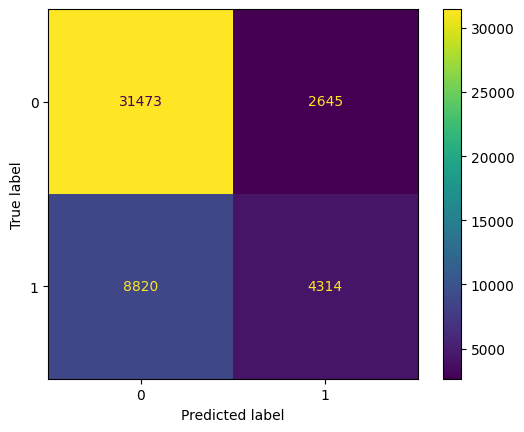

In [17]:
y_pred_prob = clf_xgb.predict_proba(X_test)[:,-1]
threshold = 0.5
y_pred = y_pred_prob > threshold



cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_xgb.classes_ ,)
disp.plot()

In [91]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85     34118
           1       0.62      0.33      0.43     13134

    accuracy                           0.76     47252
   macro avg       0.70      0.63      0.64     47252
weighted avg       0.74      0.76      0.73     47252



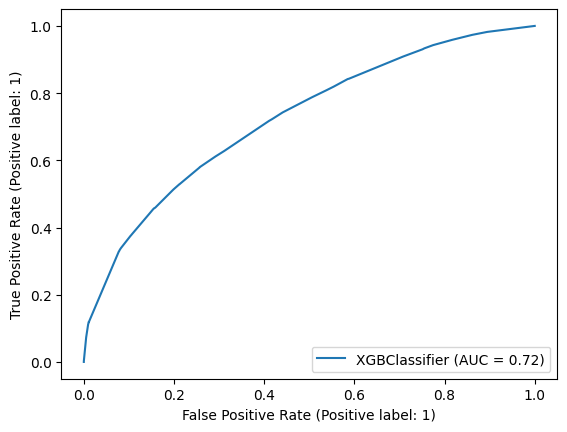

In [86]:
RocCurveDisplay.from_estimator(clf_xgb, X_test, y_test)

In [70]:
feature_importances = []
for i in range(len(clf_xgb.feature_names_in_)):
    feature_importances.append({'Feature':clf_xgb.feature_names_in_[i],
                            'feature_importance':clf_xgb.feature_importances_[i]})
feature_importances = pd.DataFrame(feature_importances)
feature_importances.sort_values(by='feature_importance', ascending=False).head(20)

,Feature,feature_importance
65,P1_MAR_STATUS_P,0.235492
86,LEGAL_ADDON_PRE_REN_Y,0.129818
84,PAYMENT_METHOD_NonDD,0.107650
29,QUOTE_DATE_FLAG,0.079859
92,KEYCARE_ADDON_PRE_REN_Y,0.042482
55,AD_BUILDINGS_Y,0.032681
85,PAYMENT_METHOD_PureDD,0.032481
87,LEGAL_ADDON_POST_REN_Y,0.032110
16,PAYMENT_FREQUENCY,0.023655
95,HP1_ADDON_POST_REN_Y,0.020984


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

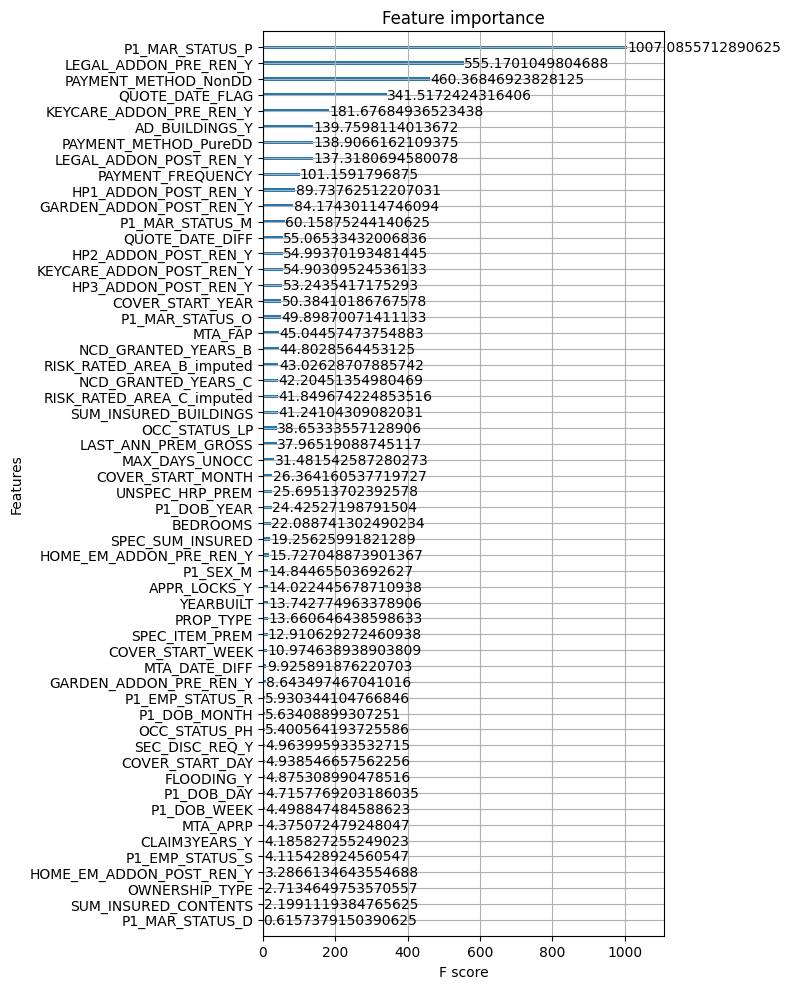

In [85]:
fig, ax = plt.subplots(1,1, figsize = (8,10), tight_layout=True)
xgb.plot_importance(clf_xgb, importance_type='gain', ax = ax)

Model overview:
- 76% accuracy, AUC of 0.72 would indicate the model has OK predictive performance. 
- However, a closer look at the confusion matrix (for p=0.5) and classification report indicate where the poor performance is. The model creates a lot of false negatives, shown by the poor recall value of 0.33 and F1 score 0.43. 
- This is where the business application comes in. There is a very real cost to these false negatives as these indicate customers whose policies have lapsed - it is assumed the model should focus on these in further development.
- Most significant features appear to be P1_MAR_STATUS_P, LEGAL_ADDON_PRE_REN_Y, PAYMENT_METHOD_NonDD, QUOTE_DATE_FLAG, KEYCARE_ADDON_PRE_REN_Y.
- early stopping used to prevent overfitting.

## Optimising parameters woth cross-validation and gridsearch

In [118]:
# scale_pos_weight parameter may help with imbalanced classes

# Round 1 
#param_grid = {
#    'max_depth':[4,5,6,7],
#    'gamma':[0.05, 0.1, 0.25, 0.5],
#    'min_child_weight':[0.1, 1, 2, 3],
#    'learning_rate': [0.01, 0.1, 1, 10],
#    'reg_lambda':[0.1,1,10, 100],
#    'scale_pos_weight':[1,3,5, 10, 20]
#}

# Round 2 
#param_grid = {
#    'max_depth':[5,6,7,8,9],
#    'gamma':[0.05, 0.1, 0.25],
#    'min_child_weight':[0.1, 1, 2, 3],
#    'learning_rate': [0.05, 0.1, 0.25],
#    'reg_lambda':[5,10,12],
#    'scale_pos_weight':[1,3,5, 10, 20]
#}

# Round 3 
"""
param_grid = {
    'max_depth':[5], #Tseng (2018) - shouldn't need to go above 5.
    'gamma':[0.01, 0.025, 0.05],
    'min_child_weight':[1, 2, 3],
    'learning_rate': [0.2, 0.25, 0.35, 0.5],
    'reg_lambda':[10],
    'scale_pos_weight':[2,3,5]
}

optimal_params = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample = 0.9,
                                colsample_bytree = 0.5,
                                early_stopping_rounds=10,
                                eval_metric=roc_auc_score),
    param_distributions=param_grid,
    scoring = 'roc_auc', #Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    n_jobs = -1,
    n_iter = 100,
    verbose = 2,
    cv = 3,
)

optimal_params.fit(X_train,
                    y_train,
                    eval_set=[(X_test, y_test)],
                    verbose=False)
"""

2022/09/12 23:05:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '76843bd827324462b5191519643b094a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/09/12 23:05:06 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x7f64b9ee81f0>,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delt...`


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END gamma=0.01, learning_rate=0.35, max_depth=5, min_child_weight=2, reg_lambda=10, scale_pos_weight=5; total time=   5.6s
[CV] END gamma=0.01, learning_rate=0.35, max_depth=5, min_child_weight=2, reg_lambda=10, scale_pos_weight=2; total time=   6.3s
[CV] END gamma=0.01, learning_rate=0.35, max_depth=5, min_child_weight=2, reg_lambda=10, scale_pos_weight=2; total time=   6.4s
[CV] END gamma=0.01, learning_rate=0.35, max_depth=5, min_child_weight=2, reg_lambda=10, scale_pos_weight=2; total time=   6.3s
[CV] END gamma=0.01, learning_rate=0.35, max_depth=5, min_child_weight=2, reg_lambda=10, scale_pos_weight=5; total time=   5.1s
[CV] END gamma=0.01, learning_rate=0.35, max_depth=5, min_child_weight=2, reg_lambda=10, scale_pos_weight=5; total time=   5.0s
[CV] END gamma=0.025, learning_rate=0.2, max_depth=5, min_child_weight=1, reg_lambda=10, scale_pos_weight=3; total time=   5.5s
[CV] END gamma=0.025, learning_rate=0.2, 

2022/09/12 23:10:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jordan/insurance_data_science/venv/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2022/09/12 23:10:34 INFO mlflow.sklearn.utils: Logging the 5 best runs, 95 runs will be omitted.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.5,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric=<function roc_auc_score at 0x7f64b9ee81f0>,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'gamma': [0.01, 0.025, 0.05],
                                        'learning_rate': [0.2, 0.25, 0.35, 0.5],
                                        'max_depth': [5],
                                        'min_child_weight': [1, 2, 3],
                                        'reg_lambda': [10],
                                        'scale_pos_weight': [2, 3, 5]},
                   scoring='roc_auc', verbose=2)

In [123]:
print(optimal_params.best_estimator_.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'early_stopping_rounds': 10, 'enable_categorical': False, 'eval_metric': <function roc_auc_score at 0x7f64b9ee81f0>, 'gamma': 0.05, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.35, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 5, 'max_leaves': 0, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 10, 'sampling_method': 'uniform', 'scale_pos_weight': 3, 'subsample': 0.9, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'seed': 42}


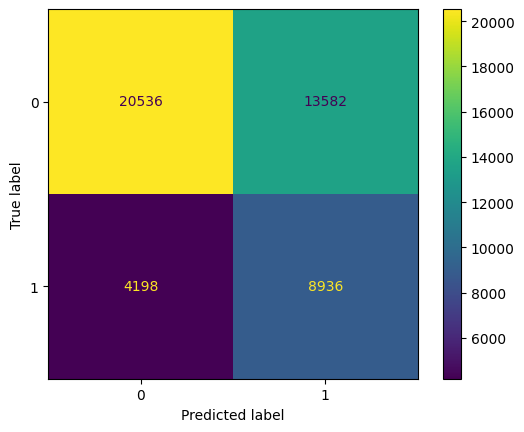

In [120]:
y_pred_prob = optimal_params.best_estimator_.predict_proba(X_test)[:,-1]
threshold = 0.5
y_pred = y_pred_prob > threshold

cm = confusion_matrix(y_test, y_pred, labels=optimal_params.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=optimal_params.best_estimator_.classes_ ,)
disp.plot()

In [121]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.60      0.70     34118
           1       0.40      0.68      0.50     13134

    accuracy                           0.62     47252
   macro avg       0.61      0.64      0.60     47252
weighted avg       0.71      0.62      0.64     47252



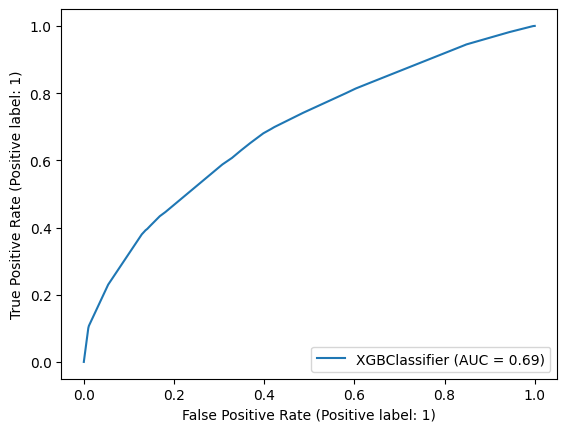

In [122]:
RocCurveDisplay.from_estimator(optimal_params.best_estimator_, X_test, y_test)

In [19]:
clf_xgb2 = xgb.XGBClassifier(objective = 'binary:logistic', 
                            early_stopping_rounds=10,
                            scale_pos_weight = 3,
                            min_child_weight= 3,
                            learning_rate = 0.35,
                            max_depth = 5,
                            reg_lambda = 10,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_jobs=-1,
                            seed = 42,
                            eval_metric=roc_auc_score
                            )
clf_xgb2.fit(X_train, 
            y_train,
            verbose = True, 
            eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.66833	validation_0-roc_auc_score:0.69203
[1]	validation_0-logloss:0.65512	validation_0-roc_auc_score:0.72354
[2]	validation_0-logloss:0.64364	validation_0-roc_auc_score:0.73154
[3]	validation_0-logloss:0.63961	validation_0-roc_auc_score:0.73380
[4]	validation_0-logloss:0.63471	validation_0-roc_auc_score:0.73750
[5]	validation_0-logloss:0.63230	validation_0-roc_auc_score:0.73900
[6]	validation_0-logloss:0.62526	validation_0-roc_auc_score:0.74420
[7]	validation_0-logloss:0.62196	validation_0-roc_auc_score:0.74741
[8]	validation_0-logloss:0.61817	validation_0-roc_auc_score:0.74851
[9]	validation_0-logloss:0.61644	validation_0-roc_auc_score:0.75002
[10]	validation_0-logloss:0.61355	validation_0-roc_auc_score:0.75301


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x7f57f321eca0>, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.35, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=10, ...)

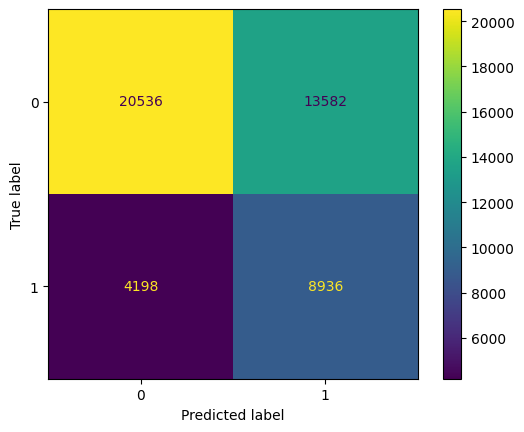

In [28]:
y_pred_prob = clf_xgb2.predict_proba(X_test)[:,-1]
threshold = 0.5
y_pred = y_pred_prob > threshold

cm = confusion_matrix(y_test, y_pred, labels=clf_xgb2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_xgb2.classes_ ,)
disp.plot()

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.60      0.70     34118
           1       0.40      0.68      0.50     13134

    accuracy                           0.62     47252
   macro avg       0.61      0.64      0.60     47252
weighted avg       0.71      0.62      0.64     47252



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

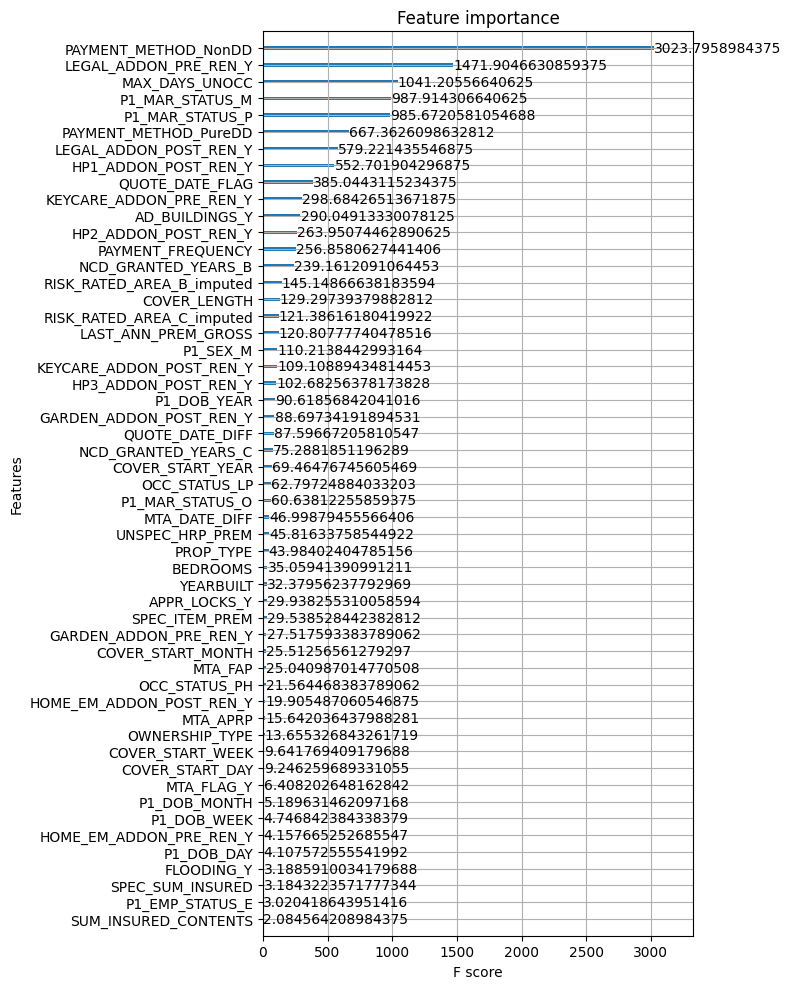

In [30]:
fig, ax = plt.subplots(1,1, figsize = (8,10), tight_layout=True)
xgb.plot_importance(clf_xgb2, importance_type='gain', ax = ax)

Re-training the XGBoost model on the optimal parameters found from the random search has not yielded major performance improvements. 
Previously, F1-score was 0.43, and recall was 0.33. Now it is 0.5 and 0.68 respectively which is a minor improvement. 
The decrease in false negatives has come at a cost of an increase in false positives, this is considered to be an acceptable trade-off as (presumably) we are not as concerned with false positives as we are with the more costly false negative.
The AUC of the "optimised" model is slightly lower than before which is concerning and cause for further investigation.

# 3. Conclusions

The conclusions here focus on promising areas of further development:
1. Establishing the cost of the lapsed policies: further work should go into understanding the true cost of a false negative. This may inform a marketing investment - targeting advertisements at those who are flagged as likely to lapse. Any marketing materials should be monitored to ensure that it does not have an adverse effect on cases not expected to lapse.
2. Additional work on hyper-parameter tuning with hyperopt library.
3. Feature engineering

Additional comments:
- Are there any ethical concerns with data including age, gender etc. 
